# AdaBoost

Python 3.9.4
<br><b>Authors:</b>
<br>Dor Azaria 206333452 (implementation, visualization)
<br>Egor Kononov 342426608 (implementation, visualization)
<br>We worked on the algorithm together

Boosting is an ensemble technique that attempts to create a strong classifier from a number of weak classifiers.
<br>AdaBoost also called Adaptive Boosting is a technique in Machine Learning used as an Ensemble Method.
<br>AdaBoost can be used to boost the performance of any machine learning algorithm. It is best used with weak learners. These are models that achieve accuracy just above random chance on a classification problem.
* Boosting and how it is a general technique that keeps adding weak learners to correct classification errors.
* AdaBoost as the first successful boosting algorithm for binary classification problems.
* Learning the AdaBoost model by weighting training instances and the weak learners themselves.
* Predicting with AdaBoost by weighting predictions from weak learners.

#### Input
- Set $S$ of points, $x_i\in S$, with labels $y_i$
- Number of iterations $k$
- A set $H$ of $T$ (weak) classifiers, $h_j : S \rightarrow \{ -1,1 \} ^{|S|}$

#### Output 
- a weight $\alpha _j$ for each classifier $h_j$

#### Final decision function
- $F(x) = \sum_{t=1}^{T} \alpha _t h_t (x)  $
- $H(x) = sign[F(x)]$

## Algorithm Steps

1. Initialize point weights $𝐷_1 (𝑥_𝑖 )= \frac{1}{n}$
2. For iteration $t=1,…,k$
3.    Compute weighted error for each $h \in H$: <br>
		$𝜖_𝑡 (ℎ)= \sum_{i=1}^{n} 𝐷_t (𝑥_𝑖 ) \{ h(x_i ) \ne y_i \} $
4.    Select classifier with min weighted error <br>
		$ℎ_𝑡 =𝑎𝑟𝑔𝑚𝑖𝑛_ℎ  𝜖_𝑡 (ℎ)$
5.    Set classifier weight 𝛼_𝑡 based on its error <br>
		$𝛼_𝑡 = \frac{1}{2} \ln⁡{ \frac{1−𝜖_𝑡 (ℎ_𝑡)}{𝜖_𝑡 (ℎ_𝑡)}}$
6.    Update point weights <br>
		 $𝐷_{𝑡+1} (𝑥_𝑖 ) = \frac{1}{𝑍_𝑡} 𝐷_𝑡(𝑥_𝑖 ) 𝑒^{−\alpha _𝑡 ℎ_𝑡 (𝑥_𝑖 ) 𝑦_𝑖 }$ <br>
         where $Z_t$ is a normalizing constant giving $\sum_{i} 𝐷_{𝑡+1} (𝑥_𝑖 ) =1$

In [71]:
from pandas.plotting import radviz
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd

data_frame = pd.read_table("rectangle.txt",header=None, index_col=False, names=['x', 'y', 'label'], delimiter=r"\s+")

By functional definition we know: $h_j : S \rightarrow \{ -1,1 \} ^{|S|}$
<br> As for each given point we need to know if it's misclassified

In [73]:
class LinearRule:
    
    # a simple line y = xm+b
    def __init__(self, m, b, x=0, direction=1, parallel="horizontal", weight=0):
        self.x = x # x-axis pass
        self.m = m # incline
        self.b = b # bias
        self.weight = weight # 0 or more 
        self.direction = direction # 1 or -1
        self.parallel = parallel # horizontal or vertical
        
        
    """
        This method classifies the given point to this rule
        If the line is horizontal, we'll check for y-axis
        else we'll check for x-axis
    """
    def classification(self, point):
        result = 0
        
        if self.parallel == "horizontal":
            y = point[0]*self.m + self.b
            
            if point[1] >= y: # if it's above the current line
                result = 1
            else:
                result = -1
        
        else: # if it's vertical
            
            if point[0] >= self.x: # if it's on the right side of the line
                result = 1
            else:
                result = -1
                
        return self.direction * result

In [74]:

def generate_lines(data_frame):
    rules = list()
    
    for index1, point1 in data_frame.iterrows():
        for index2, point2 in data_frame.iterrows():
            
            if index2 > index1 or index1 != index2 :
                
                rule1 = generate_directed_line(point1, point2, 1)                
                if rule1 not in rules:
                    rules.append(rule1)
                    
                rule2 = generate_directed_line(point1, point2, -1)
                if rule2 not in rules:
                    rules.append(rule2)
                    
    return rules
                    
def generate_directed_line(point1, point2, direction):
    
    if point1[0] == point2[0]: # is vertical
        return LinearRule(0, 0, point1[0], direction, "vertical")
    
    elif point1[1] == point2[1]: # is horizontal
        return LinearRule(0, point1[1], 0, direction, "horizontal")
    
    else:
        m = (point1[1] - point2[1]) / (point1[0] - point2[0]) # (y0-y1)/(x0-x1)
        b = point1[1] - m*point1[0]
        return LinearRule(m, b, 0, direction)

* points_weights theoretically initialized as $𝐷_1 (𝑥_𝑖 )= \frac{1}{n}$
* getSign method theoretically mentioned as $H(x) = sign[F(x)]$
* updateWeights method theoretically mentioned as $𝐷_{𝑡+1} (𝑥_𝑖 ) = \frac{1}{𝑍_𝑡} 𝐷_𝑡(𝑥_𝑖 ) 𝑒^{−\alpha _𝑡 ℎ_𝑡 (𝑥_𝑖 ) 𝑦_𝑖 }$
* getBestRules method theoretically mentioned as $𝛼_𝑡 = \frac{1}{2} \ln⁡{ \frac{1−𝜖_𝑡 (ℎ_𝑡)}{𝜖_𝑡 (ℎ_𝑡)}}$ and $ℎ_𝑡 =𝑎𝑟𝑔𝑚𝑖𝑛_ℎ  𝜖_𝑡 (ℎ)$

In [77]:

class AdaboostAlgorithm:
    
    def __init__(self, data_frame):
        self.df = data_frame
        self.results = list()
        self.important_lines = list()
        
    
    def learn(self, num_of_best_rules, iterations):
        self.results = np.zeros((num_of_best_rules, 2))
        train_data = self.df
        test_data = self.df
        
        for i in range(iterations):
            df_shuffled = self.df.sample(frac=1).reset_index(drop=True)
            train_data, test_data = np.vsplit(df_shuffled, 2)
            points_weights = np.full(len(train_data.index), ( 1/len(train_data.index) ))
            rules = generate_lines(train_data)
            self.getBestRules(train_data, rules, points_weights, num_of_best_rules)
            true_errors, empirical_errors = self.getErrors(num_of_best_rules, test_data, train_data)
            
            for j in range(len(self.results)):
                self.results[j,0] += true_errors[j]
                self.results[j,1] += empirical_errors[j]
                
            print(f'Iterations {i}')
            
        self.results /= iterations
        return self.important_lines, self.results
            
                
    def getErrors(self, num_of_best_rules, test_data, train_data):
        true_errors = list()
        empirical_errors = list()

        for k in range(num_of_best_rules):
            current_rules = self.important_lines[:(k+1)]
            train_results = train_data.apply(lambda point: point[2] == self.getSign(current_rules,point), axis=1, result_type='reduce')
            test_results = test_data.apply(lambda point: point[2] == self.getSign(current_rules,point), axis=1,result_type='reduce')
            train_error = len(train_results[train_results == False])/ len(train_results)
            test_error = len(test_results[test_results == False])/ len(test_results)
            
            empirical_errors.append(train_error)
            true_errors.append(test_error)
            
        return (true_errors, empirical_errors)
            
            
    def getSign(self, current_rules, point):
        weight_sum = 0
        
        for rule in current_rules:
            weight_sum += rule.weight * rule.classification(point)

        return np.sign(weight_sum)
    

    def getBestRules(self, train_data, rules, points_weights, num_of_best_rules):
        self.important_lines = list()

        for i in range(num_of_best_rules):
            epsilon = sys.maxsize # infinity 
            minimal_rule = rules[0]
            
            for rule in rules:
                temp_epsilon = 0
                consistent = train_data.apply(lambda point: point[2] == rule.classification(point), axis=1, result_type='reduce')

                for point_index in consistent[consistent == False].index:
                    temp_epsilon += points_weights[point_index]

                if temp_epsilon <= epsilon:
                    epsilon = temp_epsilon
                    minimal_rule = rule
            
            alpha_weight = (np.log((1 - epsilon) / (epsilon)))/2
            minimal_rule.weight = alpha_weight
            self.important_lines.append(minimal_rule)
            self.updateWeights(train_data, points_weights, minimal_rule)
    
    
    def updateWeights(self, train_data, points_weights, minimal_rule):
        
        for index, point in train_data.iterrows():
            alpha = minimal_rule.weight
            h = minimal_rule.classification(point)
            y = point[2]
            points_weights[index] *= (np.e ** (-alpha * h * y))
        
        points_weights /= np.sum(points_weights)


Running 100 iterations asking for 8 last strong rules.
<br> We'll get the strongest rules given by the last iteration and the results containing the average of the emperical error and true error.

In [78]:
learn_data = AdaboostAlgorithm(data_frame)
important_lines, results = learn_data.learn(8,100)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Iterations 19
Iterations 20
Iterations 21
Iterations 22
Iterations 23
Iterations 24
Iterations 25
Iterations 26
Iterations 27
Iterations 28
Iterations 29
Iterations 30
Iterations 31
Iterations 32
Iterations 33
Iterations 34
Iterations 35
Iterations 36
Iterations 37
Iterations 38
Iterations 39
Iterations 40
Iterations 41
Iterations 42
Iterations 43
Iterations 44
Iterations 45
Iterations 46
Iterations 47
Iterations 48
Iterations 49
Iterations 50
Iterations 51
Iterations 52
Iterations 53
Iterations 54
Iterations 55
Iterations 56
Iterations 57
Iterations 58
Iterations 59
Iterations 60
Iterations 61
Iterations 62
Iterations 63
Iterations 64
Iterations 65
Iterations 66
Iterations 67
Iterations 68
Iterations 69
Iterations 70
Iterations 71
It

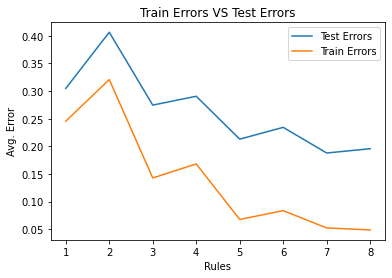

In [118]:
plt.title("Train Errors VS Test Errors")
plt.plot(results[:, 0], label="Test Errors")
plt.plot(results[:, 1], label="Train Errors")
plt.xticks(np.arange(len(results)), np.arange(1, len(results)+1))
plt.xlabel("Rules")
plt.ylabel("Avg. Error")
plt.legend()
plt.show()

In [134]:
from tabulate import tabulate

print("Report Emperical Error and True Error averaged over the 100 runs.")
rows = list()

for i in range(8):
    rows.append([f'{i+1} rules', results[i,0], results[i,1],  results[i,0]-results[i,1]])
    
tab = tabulate(rows, headers=['Rule', 'True Avg Error', 'Emperical Avg Error', 'Difference' ], tablefmt='fancy_grid')
print(tab)

Report Emperical Error and True Error averaged over the 100 runs.
╒═════════╤══════════════════╤═══════════════════════╤══════════════╕
│ Rule    │   True Avg Error │   Emperical Avg Error │   Difference │
╞═════════╪══════════════════╪═══════════════════════╪══════════════╡
│ 1 rules │         0.304933 │             0.2456    │    0.0593333 │
├─────────┼──────────────────┼───────────────────────┼──────────────┤
│ 2 rules │         0.406533 │             0.320933  │    0.0856    │
├─────────┼──────────────────┼───────────────────────┼──────────────┤
│ 3 rules │         0.274667 │             0.1428    │    0.131867  │
├─────────┼──────────────────┼───────────────────────┼──────────────┤
│ 4 rules │         0.290667 │             0.168267  │    0.1224    │
├─────────┼──────────────────┼───────────────────────┼──────────────┤
│ 5 rules │         0.213067 │             0.0677333 │    0.145333  │
├─────────┼──────────────────┼───────────────────────┼──────────────┤
│ 6 rules │         0.23